In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# paper_implementation(Transformer)

### 포지셔널 인코딩

$$ P E_{(pos,2i)} = sin(pos/10000^{2i/d_{model}}) $$
$$ P E_{(pos,2i+1)} = cos(pos/10000^{2i/d_{model}}) $$

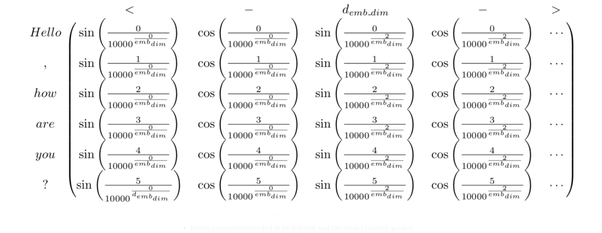

In [33]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
    # d_model : model의 dimension
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        # 위 수식에서 angle 구현하기
        angles = 1 / tf.pow(tf.constant(10000, tf.float32), tf.constant((2*i)/d_model))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # 0 ~ d_model
            d_model=d_model)

        #배열의 짝수 인덱스(2i)에는 사인 함수 적용
        sines = tf.math.sin(angle_rads[0::2])

        # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
        cosines = tf.math.cos(angle_rads[1::2])

        angle_rads = np.zeros(angle_rads.shape)
        # 각 sines, cosines 할당하기
        angle_rads[0::2] = sines
        angle_rads[1::2] = cosines

        pos_encoding = tf.constant(angle_rads)
        print(pos_encoding.shape)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [34]:
sample_pos_encoding = PositionalEncoding(50, 128)
pos = sample_pos_encoding.pos_encoding.numpy()
pos

(50, 128)
(1, 50, 128)


array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 5.4030228e-01,  6.4790583e-01,  7.3176098e-01, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [ 9.0929741e-01,  9.8704624e-01,  9.9748003e-01, ...,
          3.0798532e-08,  2.6670428e-08,  2.3095639e-08],
        ...,
        [-9.9233550e-01, -9.9016297e-01, -7.7282846e-01, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [-7.6825470e-01, -6.6357207e-01, -9.9111688e-01, ...,
          7.3916476e-07,  6.4009026e-07,  5.5429535e-07],
        [ 3.0059254e-01,  2.0752478e-02,  5.7818639e-01, ...,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00]]], dtype=float32)

### Scaled Dot-Production Attention

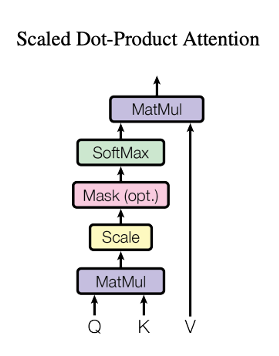

In [37]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    ############################### implementation ##################################################
    matmul_qk = tf.matmul(query, key, transpose_b=True) # 1

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    ############################### implementation ##################################################
    #  tf.math.sqrt() 이용
    logits =  matmul_qk / tf.math.sqrt(depth)# 2

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

### MultiHeadAttention

멀티 헤드 어텐션에서는 크게 두 종류의 가중치 행렬이 나왔습니다. Q, K, V 행렬을 만들기 위한 가중치 행렬인 WQ, WK, WV 행렬과 바로 어텐션 헤드들을 연결(concatenation) 후에 곱해주는 WO 행렬입니다.

멀티 헤드 어텐션의 구현은 크게 다섯 가지 파트로 구성됩니다.

1. WQ, WK, WV에 해당하는 d_model 크기의 밀집층(Dense layer)을 지나게한다.
2. 지정된 헤드 수(num_heads)만큼 나눈다(split).
3. 스케일드 닷 프로덕트 어텐션.
4. 나눠졌던 헤드들을 연결(concatenatetion)한다.
5. WO에 해당하는 밀집층을 지나게 한다.


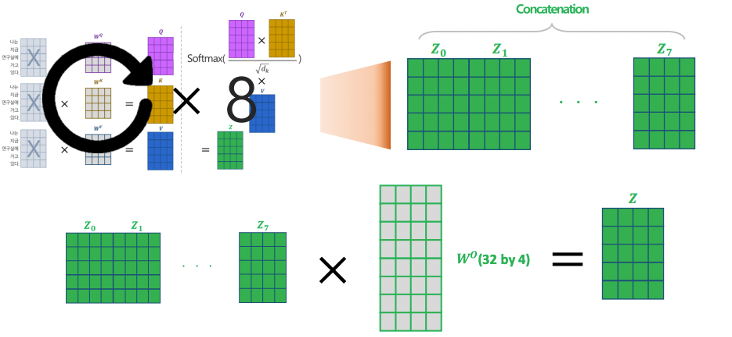

[참고] python assert    
assert는 "이 조건이 참일때 코드는 내가 보장한다. 이 조건은 올바르다!   
하지만 이 조건이 거짓이라는 것은 내가 보증하지 않은 동작이다. 그러니 AssertionError를 발생해라!" 라는 뜻입니다.

In [38]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))

        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        ############################### implementation ##################################################
        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                        (batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

입력된 정수 시퀀스에서 패딩 토큰의 인덱스인지, 아닌지를 판별하는 함수를 구현하는 것입니다. 아래의 함수는 정수 시퀀스에서 0인 경우에는 1로 변환하고, 그렇지 않은 경우에는 0으로 변환하는 함수입니다.

In [39]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, key의 문장 길이)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [40]:
# 예시
print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


### residual block

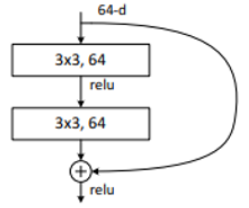

In [50]:
# 잔차 블록 : input 과 conv를 통과한 x를 더해주는 것
d_model = 64
inputs = tf.keras.Input(shape=(None, 50, d_model), name="inputs")
x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='linear')(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='linear')(x)

x = tf.keras.layers.ReLU()(inputs + x)

### 인코더

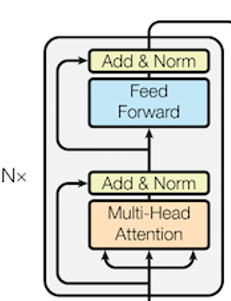

하나의 인코더 블록. 즉, 하나의 인코더 층을 구현하는 코드입니다.

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 인코더는 패딩 마스크 사용 -> 어텐션에서 패딩 토큰 제외
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    ############################### implementation ##################################################
    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    # call 함수의 입력 인자 보고 판단하기
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")()


    ############################### implementation ##################################################
    #   사용할 모듈
    #   tf.keras.layers.Dropout(rate=dropout)
    #   tf.keras.layers.LayerNormalization
    #   tf.keras.layers.Dense(units=dff, activation='relu')

    # 드롭아웃 + 잔차 연결과 층 정규화

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)

    # 드롭아웃 + 잔차 연결과 층 정규화

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

실제로 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 별도 구현합니다.

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 인코더는 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더

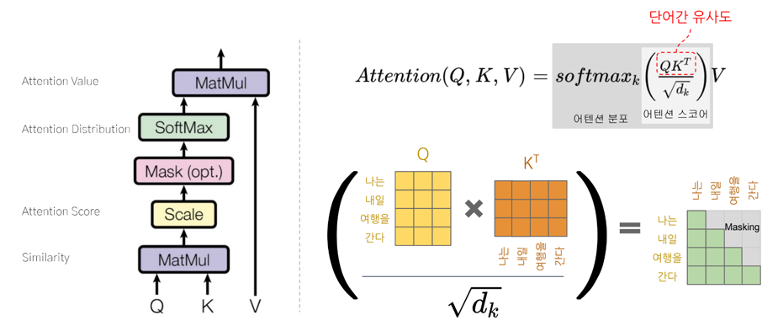

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) #  Lower triangular part.
    padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))


tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


임의의 정수 시퀀스 입력을 넣어서 결과를 봅시다. 패딩 마스크를 테스트 하기위해 세번째 위치에 정수 0을 넣었습니다. 룩-어헤드 마스크이므로 삼각형 모양의 마스킹이 형성되면서 패딩 마스크가 포함되어져 있는 세번째 열이 마스킹됩니다.

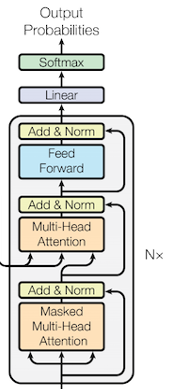

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    ############################### implementation ##################################################

    # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")()

    # 잔차 연결과 층 정규화

    # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")()

    # 드롭아웃 + 잔차 연결과 층 정규화

    # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)

    # 드롭아웃 + 잔차 연결과 층 정규화

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

포지셔널 인코딩 후 디코더 층을 num_layers의 개수만큼 쌓는 코드입니다.

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
            dropout=dropout, name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 트랜스포머 구현하기

지금까지 구현한 인코더와 디코더 함수를 조합하여 트랜스포머를 조립할 차례입니다. 인코더의 출력은 디코더에서 인코더-디코더 어텐션에서 사용되기 위해 디코더로 전달해줍니다. 그리고 디코더의 끝단에는 다중 클래스 분류 문제를 풀 수 있도록, vocab_size 만큼의 뉴런을 가지는 출력층을 추가해줍니다.

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 디코더의 입력
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더의 패딩 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더의 룩어헤드 마스크(첫번째 서브층)
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 디코더의 패딩 마스크(두번째 서브층)
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    ############################### implementation ##################################################

    # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
    enc_outputs = # 인코더의 입력은 입력 문장과 패딩 마스크

    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs =

    # 다음 단어 예측을 위한 출력층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

(9000, 128)
(1, 9000, 128)
(9000, 128)
(1, 9000, 128)


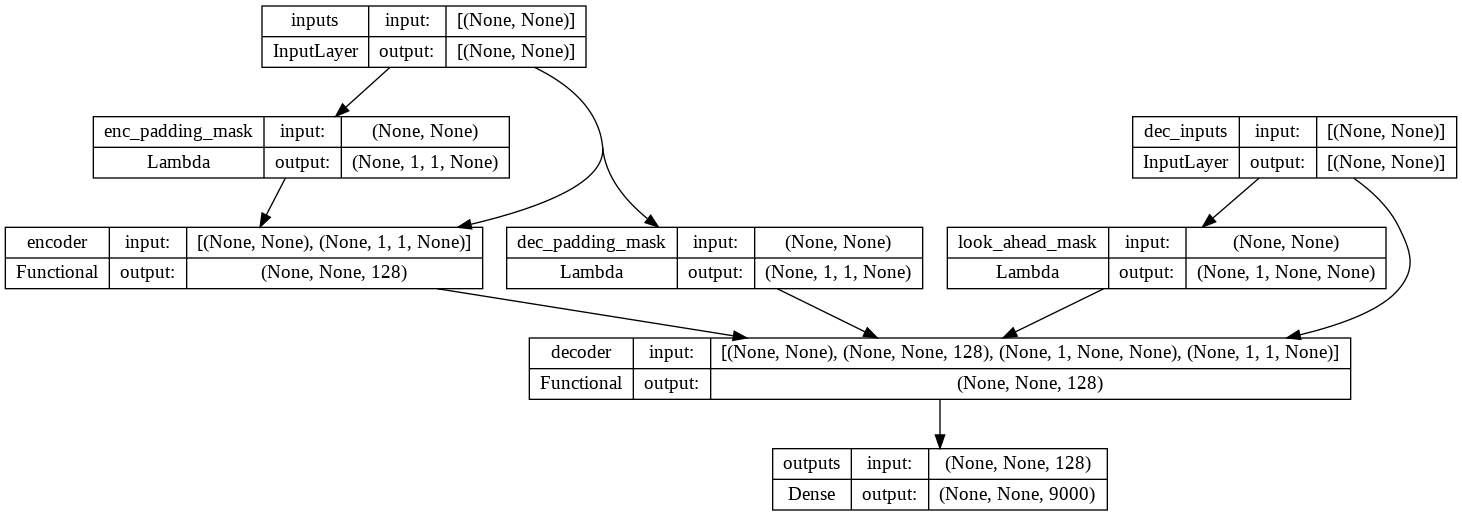

In [ ]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)